In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

def generate_data(filename,t_0,t_1,bin_size):
    #Opening the file and storing its contents line by line into a list:
    with open (filename,'r') as file:
        data = [line.rstrip() for line in file]

    #Info from file:
    channels = float(data[4])/bin_size
    ns_channel = float(data[8])*bin_size
    time_span = ns_channel*channels
    
    #Parameters for plotting
    bin_0 = int(t_0/ns_channel)
    bin_1 = int(t_1/ns_channel)
    bins = bin_1 - bin_0
    t = np.linspace(t_0,t_1,bins)

    #Removing the words from the beginning of the file:
    coincidences = data[11:-1]
    #Converting the data into a numpy array
    coincidences = np.array( list(map(int,coincidences)) )
    
    #Combining bins:
    if bin_size > 1:
        #Create new smaller array
        coincidences_new = np.zeros( int(np.size(coincidences)/bin_size) )
        for i in range( np.size(coincidences_new) ):
            coincidences_new[i] = sum(coincidences[bin_size*i:(bin_size*i+bin_size)])
        coincidences = coincidences_new[bin_0:bin_1]
    else:
        coincidences = coincidences[bin_0:bin_1]

    return t,coincidences

def dark_counts(n_c1,n_c2,n_dc,tau_c,T):
    #n_c1, n_c2: total count rate on each detector, n_dc: average dark count on the detectors
    #tau_c: bin width in ps, T: total experiment runtime in hours (integration time)
    tau_c = tau_c*1e-12
    T = T*60*60
    N_d = (n_c1 + n_c2)*n_dc*tau_c*T
    return N_d
    #Note: I believe I need to check what the count rate was on the detectors by opening the file on the computer


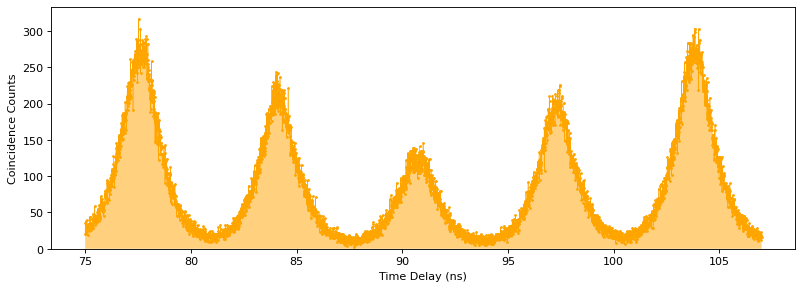

In [3]:
#Generating the plots for the co and cross polarized data 

#For 04/27/22 data
date = "04-27-22"
conditions = "_5uW_6dot5ns"
start = 75
stop = 107

time_co,coincidences_co = generate_data('resonant-HOM-co-' + date + conditions +'.dat',start,stop,1)
time_cross,coincidences_cross = generate_data('resonant-HOM-cross-' + date + conditions +'.dat',start,stop,1)

#Plotting co polarized data:
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(time_co,coincidences_co,".-",lw = '0.5', ms = '3')
plt.ylabel('Coincidence Counts')
plt.xlabel('Time Delay (ns)')
plt.fill_between(time_co,coincidences_co,alpha=0.5)
plt.ylim(bottom = 0)
#plt.ylim(top = 50)


#Plotting cross polarized data:
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(time_cross,coincidences_cross,".-",lw = '0.5', ms = '3',color = 'orange')
plt.ylabel('Coincidence Counts')
plt.xlabel('Time Delay (ns)')
plt.ylim(bottom = 0)
#plt.ylim(top = 50)
plt.fill_between(time_cross,coincidences_cross,alpha=0.5,facecolor='orange')

In [4]:
#Code for other plots

# #Plotting ontop of eachother (without difference in mean values)
# plt.figure(figsize=(12, 4), dpi=80)
# plt.plot(time_co,coincidences_co,".-",lw = '0.5', ms = '3')
# plt.plot(time_cross,coincidences_cross,".-",lw = '0.5', ms = '3')
# plt.ylabel('Coincidence Counts')
# plt.xlabel('Time Delay (ns)')
# plt.ylim(bottom = 0)
# #plt.ylim(top = 50)

# #Plotting ontop of eachother (with difference in mean values)
# plt.figure(figsize=(12, 4), dpi=80)
# plt.plot(time_co,coincidences_co - diff,".-",lw = '0.5', ms = '3')
# plt.plot(time_cross,coincidences_cross,".-",lw = '0.5', ms = '3')
# plt.ylabel('Coincidence Counts')
# plt.xlabel('Time Delay (ns)')
# #plt.ylim(bottom = 0)
# #plt.ylim(top = 50)


90.75
90.72599085365854


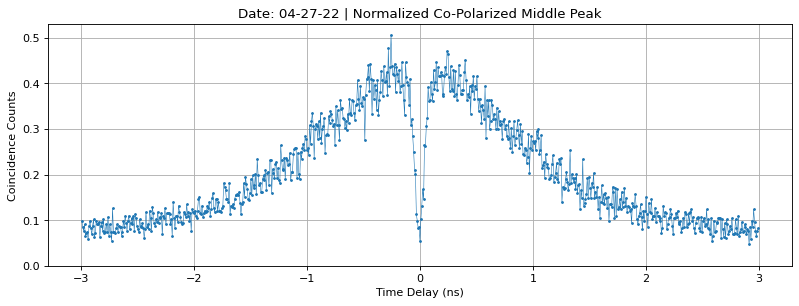

In [5]:
#Generating plots for fitting
# Here I correct for dark counts, normalize the data and shift it so the middle dip is at t = 0

#For 03/14/22 data
date = "04-27-22"
conditions = "_5uW_6dot5ns"
start = 75
stop = 106.5
middle = (start+stop)/2
print(middle)

time_co,coincidences_co = generate_data('resonant-HOM-co-' + date + conditions +'.dat',start,stop,1)
#Correcting for dark counts and normalizing
Nd = dark_counts(20000,2000,5,8,12)
coincidences_co = (coincidences_co - Nd)/max(coincidences_co)

#Finding middle peak in time by zooming into the middle peak
timeWindow = (time_co > middle-1) & (time_co < middle+1)
time_co_middle = time_co[timeWindow]
coincidences_co_middle = coincidences_co[timeWindow]
middle = time_co_middle[np.argmin(coincidences_co_middle)]
print(middle)

#Zooming out from the middle for plotting
timeWindow = (time_co > middle-3) & (time_co < middle+3)
time_co_middle = time_co[timeWindow] - middle
time_co = time_co - middle
coincidences_co_middle = coincidences_co[timeWindow]

#Plotting wide view
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(time_co,coincidences_co,".-",lw = '0.5', ms = '3')
plt.ylabel('Coincidence Counts')
plt.xlabel('Time Delay (ns)')
plt.grid(True)
#pltt.set_xticks(0)
plt.ylim(bottom = 0)
title = date+" | Normalized Co-Polarized Side Peaks"
plt.title("Date: "+title)
plt.savefig(title)

#Plotting middle view
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(time_co_middle,coincidences_co_middle,".-",lw = '0.5', ms = '3')
plt.ylabel('Coincidence Counts')
plt.xlabel('Time Delay (ns)')
plt.grid(True)
#pltt.set_xticks(0)
plt.ylim(bottom = 0)
title = date+" | Normalized Co-Polarized Middle Peak"
plt.title("Date: "+title)
plt.savefig(title)


In [6]:
#Fitting Lorentzians
#Link to fitting package documentation: https://lmfit.github.io/lmfit-py/builtin_models.html
from lmfit import Model 
from lmfit.models import LorentzianModel, ExponentialGaussianModel, VoigtModel, GaussianModel
from scipy.optimize import curve_fit
from scipy import special

sidePeakModel = ExponentialGaussianModel()

def R(z):
    return np.sqrt(2*np.pi)*(special.erf(z/np.sqrt(2)) - 1/2)/(np.exp(-1/2*z**2))

def norm_laplace(t,a,mu,sigma):
    #Overview of the Normal-Laplace distribution: https://www.math.uvic.ca/faculty/reed/NL.draft.1.pdf 
    phi = np.exp(-1/2*(t-mu)**2)/np.sqrt(2*np.pi)
    return a/2*phi*( R( a*sigma - (t-mu)/sigma ) + R( a*sigma + (y-mu)/sigma) )
    

def lorentzian(x,A,mu,sigma):
    return ( (A/np.pi)*(sigma / ( (x - mu)**2  + sigma**2 ) ) )

# Function below is based off Reimer et al. 2016 suppl info
def broadened_dist(x,A,C,d_epsilon,d_omega):
    #x = tau - tau0
    denom = 2*np.sqrt( np.pi*(1 + d_epsilon**2) )
    num = np.exp( (d_epsilon**2)*(x**2)/(1 + d_epsilon**2) ) - np.exp(-(d_omega**2)*(x**2)/4)
    return A*( np.exp(-x**2)*(num/denom) ) + C

def area_under_curve(t,fit):
    curve = lorentzian(t,fit['A'],fit['mu'],fit['sigma'])
    return np.sum(curve),curve

def get_best_fit(fit):
    return fit.best_fit

#Calculating visibility using co and cross polarized data
def visibility_co_cross(co_g2,cross_g2):
    return round((1 - co_g2/cross_g2)*100,2)

#Calculating visibility using side peaks
def visibility(opt,curves):
    [A2,A1,A0,A1p,A2p] = map(np.sum,curves)
    As = np.mean([A2,A2p])
    print(A2,A1,A0,A1p,A2p)
    print(As)

    if opt == 0:
        # Visbility equation for pulse separation distances of ~ 4-8ns
        return (1 - A0/( 2/3*(A1+A1p)/2 ))
    if opt == 1:
        # Visibility equation for pulse separation distances of 12.5ns, which I believe also applies 
        # to the 6.5ns delay in my situation.
        return (1 - A0/(As/2))

def exp_corrections(eps,R,T,g2,V_raw):
    #V = (1/eps**2)*( 2*g2 + (R**2 + T**2 )/(2*R*T) - V_raw*(2 + g2*(R**2 + T**2 )/2*R*T ) )
    V = (1/eps**2)*((R**2 + T**2)/(2*R*T) - 1 + V_raw)
    return V


In [7]:
# Determing peak locations
from scipy.signal import find_peaks
peaks, _ = find_peaks(coincidences_co, height = 0.7, distance=650)
plt.plot(coincidences_co)
plt.plot(peaks, coincidences_co[peaks], "x")
plt.show()
peakLocs = time_co[peaks]
peakLocs = np.insert(peakLocs,2,0)
print(peakLocs)

[-13.19702744  -6.71455793   0.           6.64253049  13.0929878 ]


268.1576859504132 211.9373002754821 141.08606060606058 211.29267217630854 266.7389531680441
267.44831955922865
Raw visibility : -0.055052885272034


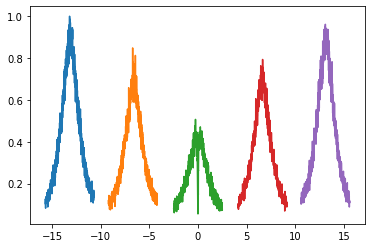

In [28]:
#Splitting up the different peaks into separate arrays given a pre defined time window

wi = 2.5 #initial fit width 

[t2,t1,t0,t1p,t2p] = map(lambda t0: time_co[ (time_co > t0 - wi) & (time_co < t0 + wi) ],peakLocs)
[P2,P1,P0,P1p,P2p] = map(lambda t0: coincidences_co[ (time_co > t0 - wi) & (time_co < t0 + wi) ],peakLocs)

#print(len(t2),len(t1))
peak_ts = np.vstack((t2,t1,t0,t1p,t2p))
peak_coincs = np.vstack(( P2,P1,P0,P1p,P2p ))

#P2 = np.take(coincidences_co,np.where(time_co == t2, )
# [P2,P1,P1p,P2p] = coincidences_co[]

plt.plot(t2,P2)
plt.plot(t1,P1)
plt.plot(t0,P0)
plt.plot(t1p,P1p)
plt.plot(t2p,P2p)

#Raw (unfitted) visibilites:
v_raw_unfit = visibility(1,[P2,P1,P0,P1p,P2p])
print("Raw visibility : "+str(v_raw_unfit))

In [21]:
#Raw visibility as a function of the integration width

#ws = np.linspace()

[  1.41038771   0.0925482   -0.68637359 -31.8016523 ]


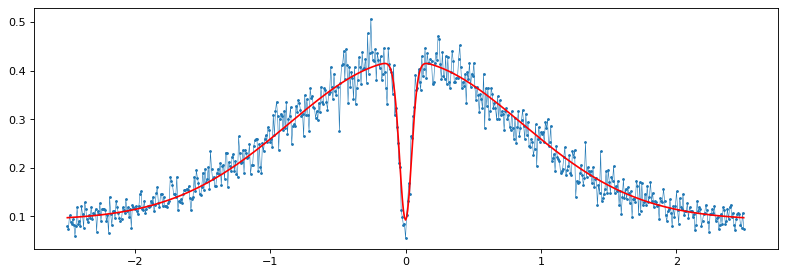

In [23]:
#Fitting middle co polarized

#Center fit
popt, pcov = curve_fit(broadened_dist, t0, P0)
print(popt)
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(t0,P0,".-",lw = '0.5', ms = '3')
plt.plot(t0, broadened_dist(t0, *popt),'r-')
#print(broadened_dist(t0, *popt))
#plt.plot(t0, broadened_dist(t0-105, *[2,3,5]))



In [11]:
# Fitting middle cross polarized

[[Model]]
    Model(expgaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 875
    # variables        = 4
    chi-square         = 1.00835133
    reduced chi-square = 0.00115769
    Akaike info crit   = -5912.16883
    Bayesian info crit = -5893.07193
[[Variables]]
    amplitude:  2.06449713 +/- 0.01046270 (0.51%) (init = 3)
    center:     86.3572336 +/- 0.01959959 (0.02%) (init = 87)
    sigma:      0.84688705 +/- 0.01123858 (1.33%) (init = 1)
    gamma:      1.66176952 +/- 0.07667580 (4.61%) (init = 0.847)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     =  0.960
    C(sigma, gamma)      =  0.840
    C(center, sigma)     =  0.807
    C(amplitude, gamma)  = -0.341
    C(amplitude, center) = -0.327
[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 875
    # variables        = 3
    chi-square         = 0.89

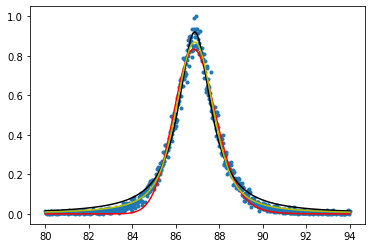

In [12]:
#Fitting side curve from a G2 measurement to find the decay parameter for the side peaks.
#Which function is best to fit?
# Options: Gaussian, Lorenztian, Voigt, Exponential-Gaussian/Normal-Laplace, 

time_g2,coincidences_g2 = generate_data('resonant-X-g2-05-04-26-nofilter-filteredpulse.dat',80,94,1)
coincidences_g2 = coincidences_g2/max(coincidences_g2)
params = sidePeakModel.make_params(amplitude = 3, center = 87, sigma = 1, gamma = 0.847)
params['gamma'].vary = True
expgauassian_fit = sidePeakModel.fit(coincidences_g2, params, x = time_g2)

lorenztian_fit = LorentzianModel().fit(coincidences_g2, x = time_g2, amplitude = 3, center = 87, sigma = 1)

params_voigt = VoigtModel().make_params(amplitude = 3, center = 87, sigma = 1, gamma = 0.847)
params_voigt['gamma'].vary = True
voigt_fit = VoigtModel().fit(coincidences_g2, params_voigt, x = time_g2)

gaussian_fit = GaussianModel().fit(coincidences_g2, x = time_g2,amplitude = 3, center = 87, sigma = 1)

plt.plot(time_g2,coincidences_g2,'.')
plt.plot(time_g2,expgauassian_fit.best_fit,'r')
plt.plot(time_g2,lorenztian_fit.best_fit,'k')
plt.plot(time_g2,voigt_fit.best_fit,'y')
print(expgauassian_fit.fit_report())
print(lorenztian_fit.fit_report())
print(voigt_fit.fit_report())

#gamma = expgauassian_fit.best_values['gamma']
#print(gamma)

In [13]:
#With set lifetime decay gamma found from the fit to the G2 side peaks, we can use this value
#in fitting the side peaks. To fit the side peaks, we will use the same function as used to fit
#the peak above but we will fix the relevant parameter at dictates the width of the fit.


#Fitting side peaks
curve = Model(sidePeakModel)
P2_fit = curve.fit(P2, x = t2, A = 180, mu = start + 14, sigma = 1.5)
P1_fit = curve.fit(P1, x = t1, A = 170, mu = mid - 7, sigma = 1.5)

P1p_fit = curve.fit(P1p, x = t1p, A = 180, mu = mid + 7, sigma = 1.5)
P2p_fit = curve.fit(P2p, x = t2p, A = 170, mu = stop - 14, sigma = 1.5)

#Fitting middle peak
P0_fit = curve.fit(P0, x = t0, A = 100, mu = mid, sigma = 1.5)

# Visibility equation for pulse separation distances of 12.5ns, which I believe also applies 
# to the 6.5ns delay in my situation.
bestfits= map(get_best_fit,[P2_fit,P1_fit,P0_fit,P1p_fit,P2p_fit])
v_raw_fit = visibility(1,bestfits)
print("Fit visibility for Thoma Eq 3: "+str(v_raw_fit))

v_corr = exp_corrections(0.95,0.5,0.5,0,v_raw_unfit)
print("Corrected visibility: "+str(v_corr))

plt.figure(figsize=(12, 4), dpi=80)
title = date+" | Normalized Co-Polarized | Fitted"
plt.plot(t_window,data_window,".-",lw = '0.5', ms = '3')
plt.plot(t2,P2_fit.best_fit,'k-')
plt.plot(t1,P1_fit.best_fit,'k-')
plt.plot(t0,P0_fit.best_fit,'k-')
plt.plot(t1p,P1p_fit.best_fit,'k-')
plt.plot(t2p,P2p_fit.best_fit,'k-')
plt.title("Date: "+title+" | V = "+str(round(100*v_corr,2)))
plt.savefig(title)

TypeError: <lmfit.Model: Model(expgaussian)> is not a callable object